In [2]:
import os 
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
# Collect all attributions in a pandas dataframe (rows = samples, columns = features)

dtypes = ['94', '131', '171', '193', '211', '304', '335', '1600', '1700', 'M_45s', 'V_45s',
        'TOTUSJH', 'TOTBSQ', 'TOTPOT', 'TOTUSJZ', 'ABSNJZH', 'SAVNCPP', 'USFLUX', 'TOTFZ',
        'MEANPOT', 'EPSZ', 'MEANSHR', 'SHRGT45', 'MEANGAM', 'MEANGBT', 'MEANGBZ', 'MEANGBH',
        'MEANJZH', 'TOTFY', 'MEANJZD', 'MEANALP', 'TOTFX', 'EPSY', 'EPSX', 'XR_MAX']

root_data_dir = '../../data/attributions/'

dfs = []
x_all = None
for file in os.listdir(root_data_dir):
    if file.endswith('.npy'):
        x = np.load(root_data_dir + file, allow_pickle=True)
        try: x_all = np.concatenate((x_all, x), axis=0)
        except: x_all = x
df = pd.DataFrame(x_all, columns=dtypes)
df = df.drop(columns=['TOTFX'])

# Calculate the mean values for each column
column_means = df.mean()

# Sort the columns based on mean values in descending order
sorted_columns = column_means.sort_values(ascending=False)

# Filter outliers
threshold = 1.1  # Adjust this value as needed
for column in sorted_columns.index:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - threshold * iqr
    upper_bound = q3 + threshold * iqr
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

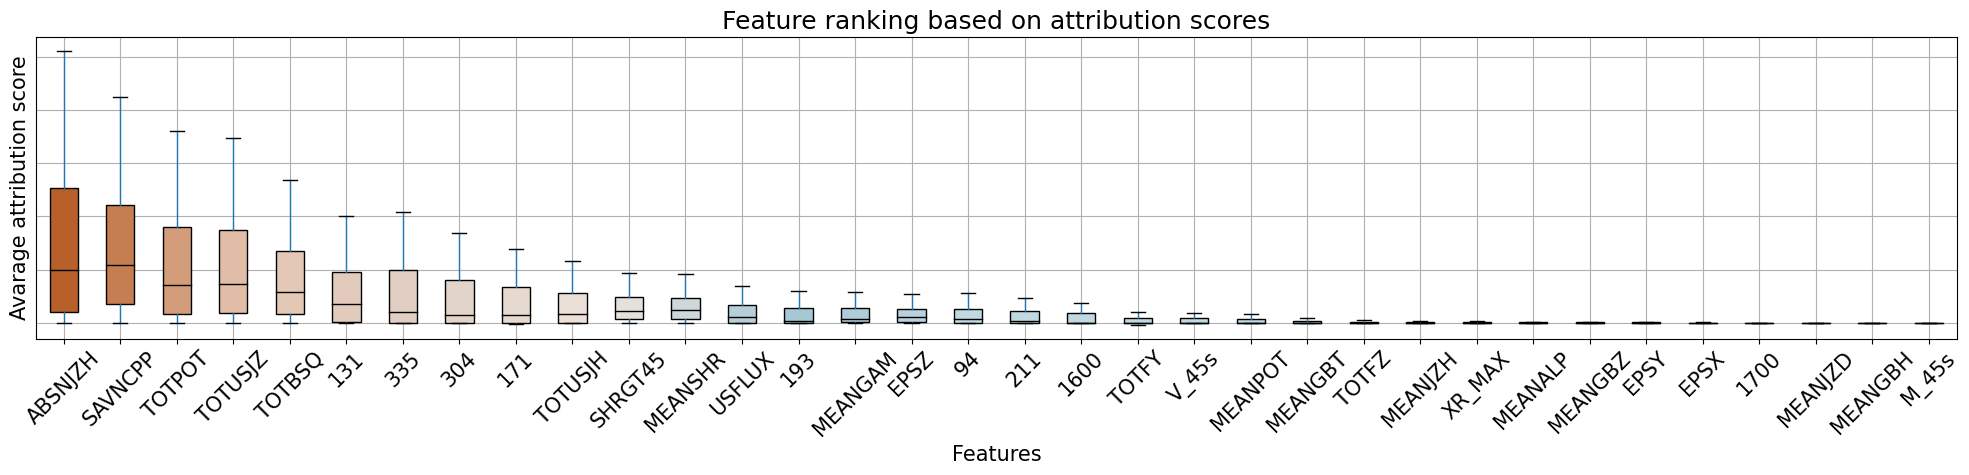

In [10]:
# Calculate the mean values for each column
column_means = df.mean()

# Sort the columns based on mean values in descending order
sorted_columns = column_means.sort_values(ascending=False)

# Generate a range of values from 0 to 1 based on the order of the columns
values = np.linspace(0, 1, int(len(column_means) / 2) )
with open('/Users/brandonlpanos/custom_cmap.pkl', 'rb') as f: custom_cmap = pickle.load(f)
# Map the values to the colormap range
colors = custom_cmap(values)
# flip the order
colors = colors[::-1]
colors = np.concatenate((colors, np.array([colors[-1]] * int(len(column_means)- len(colors)))), axis=0)

# Create a boxplot using the sorted column order
fig, ax = plt.subplots(figsize=(20, 5))
mpl.rcParams['font.size'] = 15
plt.title('Feature ranking based on attribution scores')
plt.ylabel('Avarage attribution score')
plt.xlabel('Features')
df_boxplot, props = df[sorted_columns.index].boxplot(patch_artist=True, return_type='both', ax=ax)

# Set the x-axis tick labels to the sorted column order
df_boxplot.set_xticklabels(sorted_columns.index, rotation=45)

count = 0
for patch,color in zip(props['boxes'], colors):
    patch.set_facecolor(color)
    # make color black
    patch.set_edgecolor('black')
    # Make vertical lines black
    props['medians'][count].set_color('black')
    count += 1
    props['caps'][count].set_color('black')

# get rid of y-tick labels
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()
# plt.savefig(f'/Users/brandonlpanos/papers/transformer/figs/boxplot.pdf', bbox_inches='tight')
plt.show()
plt.close()